In [1]:
%matplotlib inline
import baltic as bt
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
import re

from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from matplotlib import gridspec ## for composite figures
import matplotlib.patheffects as path_effects ## for elegant text
from IPython.display import HTML

from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import math
import time
import sys
import unicodedata
import pandas as pd
from collections import OrderedDict
import numpy as np

import json ## used for importing JSONs
try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
def removeDiacritics(string):
    """
    Removes diacritic marks from unicode.
    """
    return unicodedata.normalize('NFKD', string)
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
palms=pd.read_csv('../data_files/GBIF_arecaceae_onlynative_20220425.csv', sep='\t')#.dropna(subset=['shape'])
# palms.columns
palms_spp=pd.read_csv('../data_files/palms_alltraits_curated_20220620.csv',sep='\t')
# palms_spp['shape']=palms_spp['shape'].replace(np.nan,'none')
# palms_spp['tip_name']=palms_spp['tip_name'].replace(np.nan,'none')
print(palms_spp['shape'].unique())
print(len(palms))

['pinnate' nan 'entire' 'variable' 'cospalmate' 'bipinnate']
124703


In [3]:
list(palms_spp.columns)
len(palms_spp['tip_name'].unique())

2072

In [4]:
## for the gbif data
list(palms.columns)
shape_dict=dict(zip(palms_spp['tip_name'],palms_spp['shape']))
# for row in palms.itertuples():
#     if row.variation=='variable':
#         palms.loc[row.Index,'shape']='variable'
palms['shape']=''
palms.loc[palms.index,'shape']=palms['species'].map(shape_dict)
print(palms['shape'].unique())

['pinnate' 'variable' 'cospalmate' nan 'bipinnate' 'entire']


In [5]:
for spp in palms[palms['shape'].isna()]['species'].unique():
    if str(spp) in list(palms_spp['tip_name']):
        print(spp)
    else:
        print('missing: ',spp)

missing:  Calamus_australis
missing:  Calamus_formosanus
missing:  Plectocomia_himalayana
missing:  Calamus_muelleri
missing:  Calamus_gamblei
missing:  Calamus_moti
missing:  Calamus_radicalis
missing:  Desmoncus_orthacanthos
missing:  Desmoncus_polyacanthos
missing:  Calamus_tetradactylus
missing:  Desmoncus_moorei
missing:  Calamus_leptospadix
missing:  Laccosperma_secundiflorum
missing:  Eremospatha_macrocarpa
missing:  Calamus_rhabdocladus
missing:  Plectocomia_elongata
missing:  Calamus_albidus
missing:  Calamus_gibbsianus
missing:  Calamus_javensis
missing:  Calamus_deerratus
missing:  Calamus_ornatus
missing:  Calamus_marginatus
missing:  Calamus_caryotoides
missing:  Desmoncus_chinantlensis
missing:  Chamaedorea_elatior
missing:  Desmoncus_horridus
missing:  Laccosperma_opacum
missing:  Laccosperma_laeve
missing:  Calamus_hirsutus
missing:  Calamus_palembanicus
missing:  Calamus_conirostris
missing:  Calamus_rotang
missing:  Calamus_megaphyllus
missing:  Calamus_optimus
missin

In [6]:
# sanity check:
palms_spp.dropna(axis=0,subset='tip_name',inplace=True)
print(palms_spp[palms_spp['tip_name'].str.contains('Geonoma')][['tip_name','shape']].sort_values('tip_name',ascending=True))

                    tip_name     shape
857     Geonoma_aspidiifolia   pinnate
858       Geonoma_baculifera  variable
859         Geonoma_bernalii  variable
860          Geonoma_braunii  variable
861         Geonoma_brenesii   pinnate
..                       ...       ...
919       Geonoma_triglochin  variable
920          Geonoma_trigona    entire
921  Geonoma_umbraculiformis  variable
922           Geonoma_undata  variable
923           Geonoma_venosa  variable

[68 rows x 2 columns]


In [7]:
# this dataset should contain all coordinate records for the species, not a unique record for species annotated with variables
# palms.dropna(axis=0,subset='shape',inplace=True)
print(palms[palms['species'].str.contains('Geonoma')][['species','shape']].sort_values('species',ascending=True))

                     species     shape
41672   Geonoma_aspidiifolia   pinnate
79110   Geonoma_aspidiifolia   pinnate
79094   Geonoma_aspidiifolia   pinnate
23704   Geonoma_aspidiifolia   pinnate
99451   Geonoma_aspidiifolia   pinnate
...                      ...       ...
103220        Geonoma_undata  variable
6605          Geonoma_venosa  variable
104339        Geonoma_venosa  variable
78658         Geonoma_venosa  variable
118057        Geonoma_venosa  variable

[11252 rows x 2 columns]


In [8]:
# Annotate GBIF data to plot the maps later. Adding morphology and canopy
spp_ai=dict(zip(palms_spp['tip_name'],10**palms_spp['CHELSA_ai']))
spp_bio1=dict(zip(palms_spp['tip_name'],10**palms_spp['CHELSA_bio1']))
spp_bio4=dict(zip(palms_spp['tip_name'],10**palms_spp['CHELSA_bio4']))
spp_bio12=dict(zip(palms_spp['tip_name'],10**palms_spp['CHELSA_bio12']))
spp_bio15=dict(zip(palms_spp['tip_name'],10**palms_spp['CHELSA_bio15']))
spp_rachis=dict(zip(palms_spp['tip_name'],10**palms_spp['Max_Rachis_Length_m']))
spp_height=dict(zip(palms_spp['tip_name'],10**palms_spp['StemHeightBladeLength']))
spp_canopy=dict(zip(palms_spp['tip_name'],palms_spp['UnderstoreyCanopy']))
spp_heightovercanopy=dict(zip(palms_spp['tip_name'],10**palms_spp['HeightOverCanopy']))


palms['CHELSA_ai']=palms['species'].map(spp_ai)
palms['CHELSA_bio1']=palms['species'].map(spp_bio1)
palms['CHELSA_bio4']=palms['species'].map(spp_bio4)
palms['CHELSA_bio12']=palms['species'].map(spp_bio12)
palms['CHELSA_bio15']=palms['species'].map(spp_bio15)
palms['Max_Rachis_Length_m']=palms['species'].map(spp_rachis)
palms['StemHeightBladeLength']=palms['species'].map(spp_height)
palms['UnderstoreyCanopy']=palms['species'].map(spp_canopy)
palms['HeightOverCanopy']=palms['species'].map(spp_heightovercanopy)

In [9]:
palms[['species','StemHeightBladeLength','HeightOverCanopy']]

species  StemHeightBladeLength  HeightOverCanopy
0               Oenocarpus_bataua                  43.10      2.754167e+00
1             Manicaria_saccifera                  32.75      2.058333e+00
2                Bactris_barronis                  13.54      2.475294e+00
3                  Bactris_maraja                  10.87      1.493500e+00
4             Bactris_coloradonis                  15.19      1.419000e+11
...                           ...                    ...               ...
124698            Raphia_sudanica                  21.00      2.000000e+11
124699  Laccosperma_secundiflorum                    NaN               NaN
124700            Raphia_sudanica                  21.00      2.000000e+11
124701            Raphia_sudanica                  21.00      2.000000e+11
124702             Rhapis_humilis                   7.90      6.900000e+10

[124703 rows x 3 columns]

In [10]:
def polygon_area(x,y):
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    return 0.5*np.abs(main_area + correction)

In [11]:
json_path='../data_files/level3.geojson'
json_map=json.load(open(json_path,'r'))
features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here
locName='LEVEL3_COD' ## key name for each feature
total_area={} # keep track of the area of country polygones, for filtering purposes
for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=removeDiacritics(loc['properties'][locName]) ## standardised location name (remove diacritics)
    polygons[location]=[]
    location_points[location]=[]
    total_area[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        totalarea=0
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                xs=coords[:,0] ## longitudes
                ys=coords[:,1] ## latitudes
                area=polygon_area(xs,ys)
                totalarea=totalarea+area
                total_area[location]=totalarea
                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            xs=coords[:,0] ## longitudes
            ys=coords[:,1] ## latitudes
            area=polygon_area(xs,ys)
            location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
            total_area[location]=area
    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location
    polygons[location]=complete_location ## assign list of polygons to a location

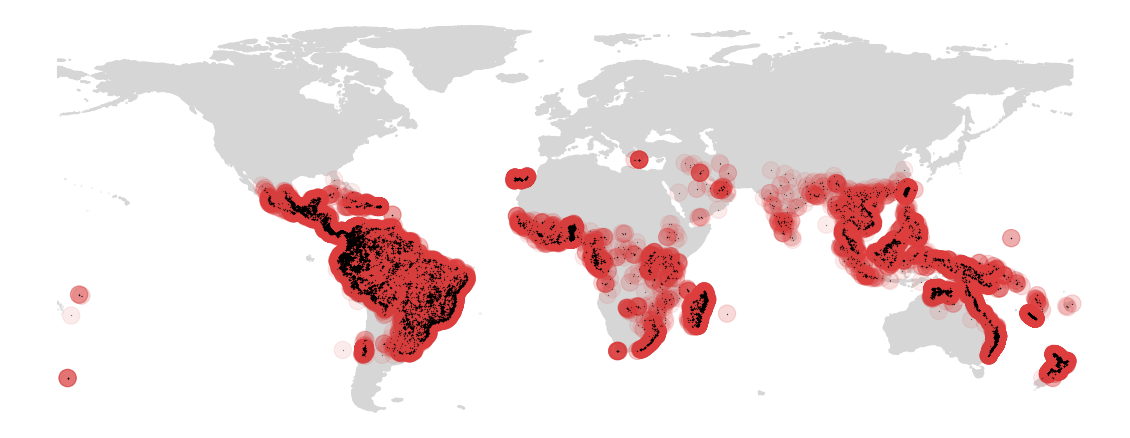

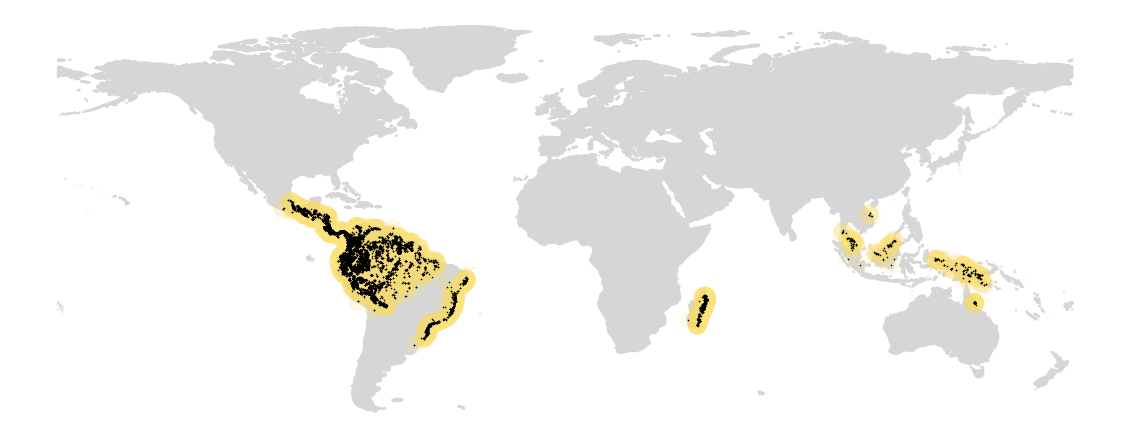

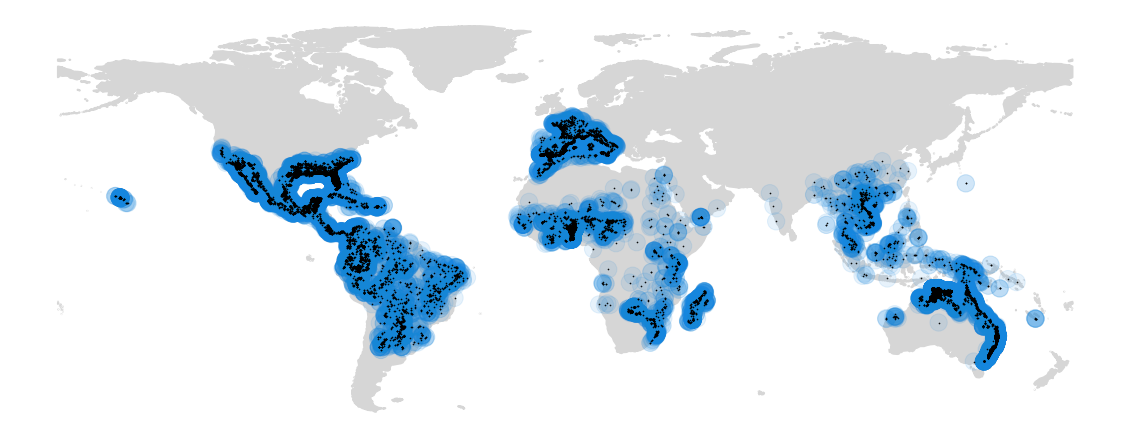

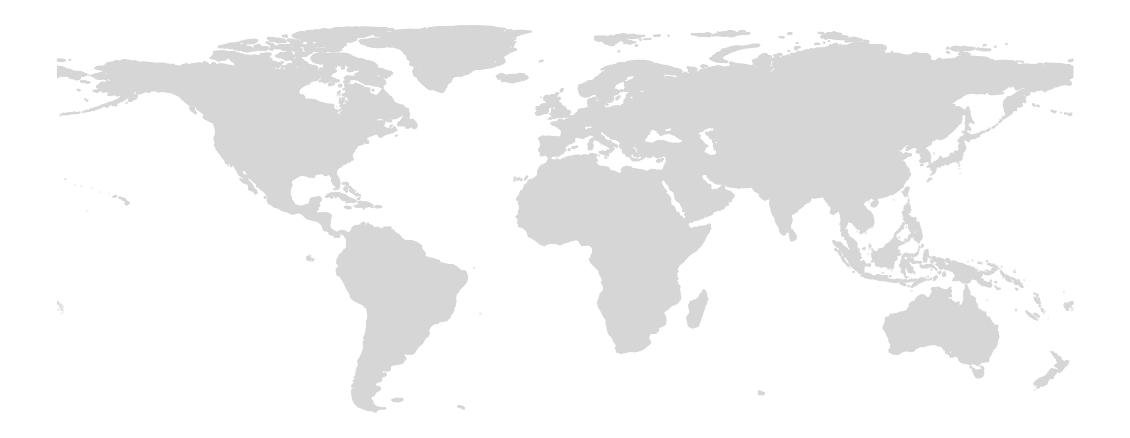

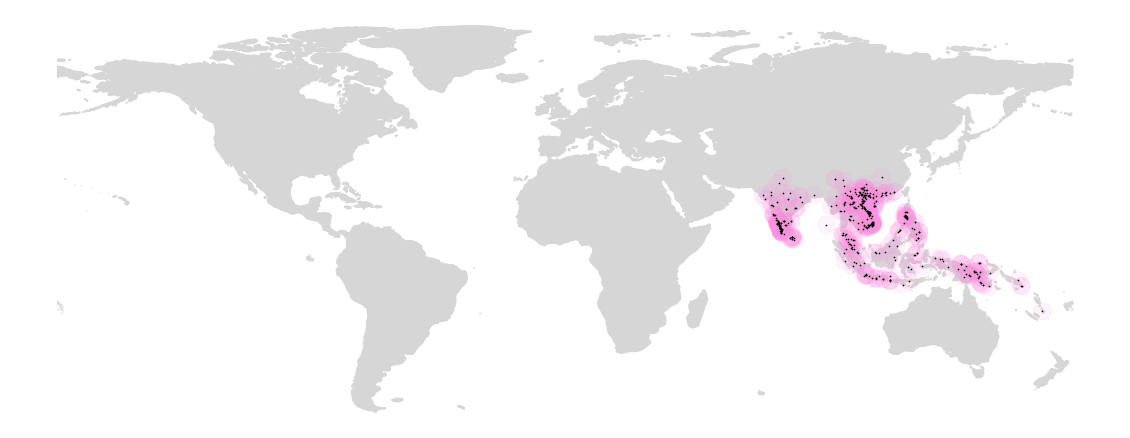

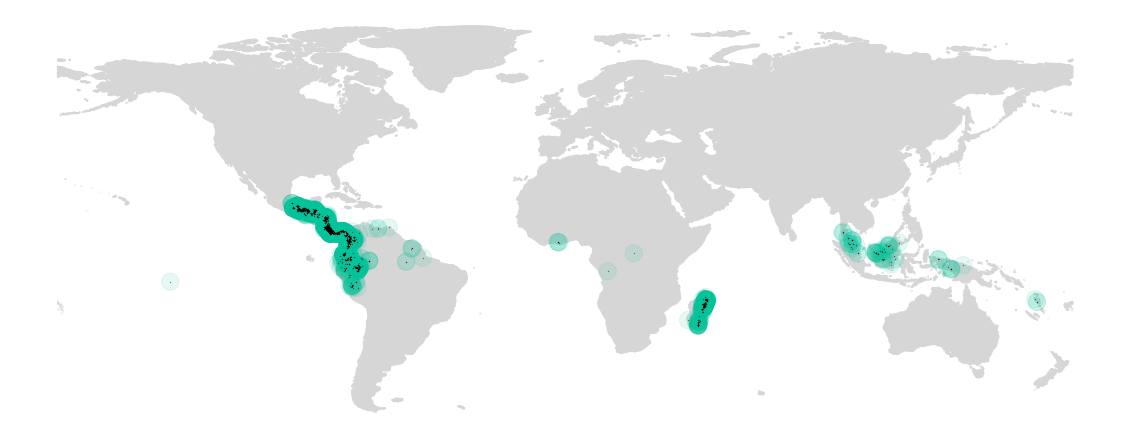

In [12]:
# colors pass greyscale differences and four colour deficiencies
shape_col_doct={'cos-palmate':"#1586DE",'cospalmate':"#1586DE", #light blue
'entire':'#02c39a', # now greensih, old: "#003480", # dark blue
'variable':"#fbe279", # yellow
'pinnate':"#dd3d3d", # red
'bipinnate':"#ff91e2",
'none':'#c9c9c9'}

for shape in palms['shape'].unique():
    fig,ax=plt.subplots(figsize=(20,7.8),facecolor='w')
    ax.set_facecolor('w')
    for loc in polygons.keys():
        if loc in total_area.keys() and 0.4 < total_area[loc] < 670:
            ax.add_collection(PatchCollection(polygons[loc],facecolor='#d6d6d6',edgecolor='#d6d6d6',alpha=1,linewidth=2))
#         if loc not in ['ATA','COK','KIR','MHL','NRU','WSM','SLB','TON','TUV','VUT','CPV','COM','MUS','MDV','STP','SYC']:
#             ax.add_collection(PatchCollection(polygons[loc],facecolor='#d6d6d6',edgecolor='#d6d6d6',alpha=1,linewidth=2)) ## plot polygons
    
    lon=palms[palms['shape']==shape]['decimalLongitude']
    lat=palms[palms['shape']==shape]['decimalLatitude']
    ax.scatter(lon,lat,marker='o',color=palms[palms['shape']==shape]['shape'].map(shape_col_doct),alpha=0.1,s=300)
    if shape in ['pinnate','entire','cos-palmate']:
        ax.scatter(lon,lat,marker='o',color='k',alpha=1,s=0.04)
    else:
        ax.scatter(lon,lat,marker='o',color='k',alpha=1,s=0.4)
#     ax.set_aspect('equal')
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(size=0)
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
#     ax.set_xlim(-165,162) ; ax.set_ylim(-40,50)
    
    plt.show()
    

In [13]:
# adding genera info from the species name
palms_spp['genus']=''
for index,row in palms_spp.iterrows():
    tempmatch=re.search('([A-Z][a-z]+)_[a-z-]+',row['tip_name'])
    palms_spp.loc[index,'genus']=str(tempmatch.groups(1)[0]) if tempmatch else 'unknown'

In [47]:
treeFileNexus='../data_files/Clean_1_1_MCCT_nexus.nex'
cc=bt.loadNexus(treeFileNexus,absoluteTime=False,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file

cc.treeStats()
cc.drawTree()
cc.sortBranches()
cc.setAbsoluteTime(2018.0)


Tree height: 108.328870
Tree length: 18144.538310
strictly bifurcating tree
annotations present

Numbers of objects in tree: 5099 (2549 nodes and 2550 leaves)



### Shape colour directory

In [48]:
# annotated from the tree

spp_shape_col=dict(zip(palms_spp.dropna(axis=0,subset=['tip_name','shape'])['tip_name'],
                       palms_spp.dropna(axis=0,subset=['tip_name','shape'])['shape'].map(shape_col_doct)))

In [49]:
# another issue are the climbing species removed from the palms_spp dataset and the analyses
# loading the species names, creating list to add "white" colour in the phylogeny
climbing=pd.read_csv('../data_files/climbing_spp_20220620.txt',sep='\t')
print('Number of climbing species: ',len(climbing[['tip_name','shape']]))
clim_col_dict='#ffffff'

Number of climbing species:  525


In [50]:
for spp in climbing['tip_name'].dropna():
    spp_shape_col[spp]='#ffffff'
spp_shape_col['Calamus_interruptus'] # climbing

'#ffffff'

### Subfamily colour directory

In [51]:
# first, re-annotating all PalmSubfamily using the first non na occurrance
palms_spp[palms_spp['PalmSubfamily'].isna()][['tip_name','genus','PalmSubfamily']]

tempbygenus=palms_spp.dropna(axis=0,subset='PalmSubfamily').groupby('tip_name')[['tip_name','genus','PalmSubfamily']].first().copy(deep=True)
spp_subfam_dict=dict(zip(tempbygenus['tip_name'],tempbygenus['PalmSubfamily']))

# group by genus and find the first non na annotation for the family
tempbygenus=palms_spp.dropna(axis=0,subset='PalmSubfamily').groupby('genus')[['tip_name','genus','PalmSubfamily']].first().copy(deep=True)
genus_subfam_dict=dict(zip(tempbygenus['genus'],tempbygenus['PalmSubfamily']))

In [52]:
genus_subfam_dict['Desmoncus']='Arecoideae'
genus_subfam_dict['Wallaceodoxa']='Arecoideae'
genus_subfam_dict['Sabinaria']='Coryphoideae'
genus_subfam_dict['Plectocomiopsis']='Calamoideae'
genus_subfam_dict['Plectocomia']='Calamoideae'
genus_subfam_dict['Myrialepis']='Calamoideae'
genus_subfam_dict['Korthalsia']='Calamoideae'
genus_subfam_dict['Oncocalamus']='Calamoideae'
genus_subfam_dict['Eremospatha']='Calamoideae'
genus_subfam_dict['Laccosperma']='Calamoideae'

Subfam_col_dict={'Arecoideae':'#c4c4c4', #blue
'Calamoideae':'#5e5e5e', # green
'Ceroxyloideae':'#5e5e5e',# orange
'Coryphoideae':'#c4c4c4', #red
'Nypoideae':'#545454'}#,'none':'#c4c4c4'} #greyish

for k in cc.Objects:
    if isinstance(k,bt.leaf):
        cur_node=k
        while cur_node:
            if k.name in spp_subfam_dict.keys():
                cur_node.traits['subfamily']=spp_subfam_dict[k.name]
            else:
                tempmatch=re.search('([A-Z][a-z]+)_[a-z-]+',k.name)
                if str(tempmatch.groups(1)[0]) in genus_subfam_dict.keys():
                    cur_node.traits['subfamily']=genus_subfam_dict[str(tempmatch.groups(1)[0])]
                else:
                    print('Unannotated genus: ',tempmatch.groups(1)[0])
            cur_node=cur_node.parent
    
for k in cc.Objects:
    if isinstance(k,bt.leaf):
        cur_node=k
        while cur_node:
            if 'subfamily' in k.traits.keys():
                cur_node.traits['subfamcol']=Subfam_col_dict[k.traits['subfamily']]
            else:
                print('Uncoloured tip: ',k.name)
            cur_node=cur_node.parent

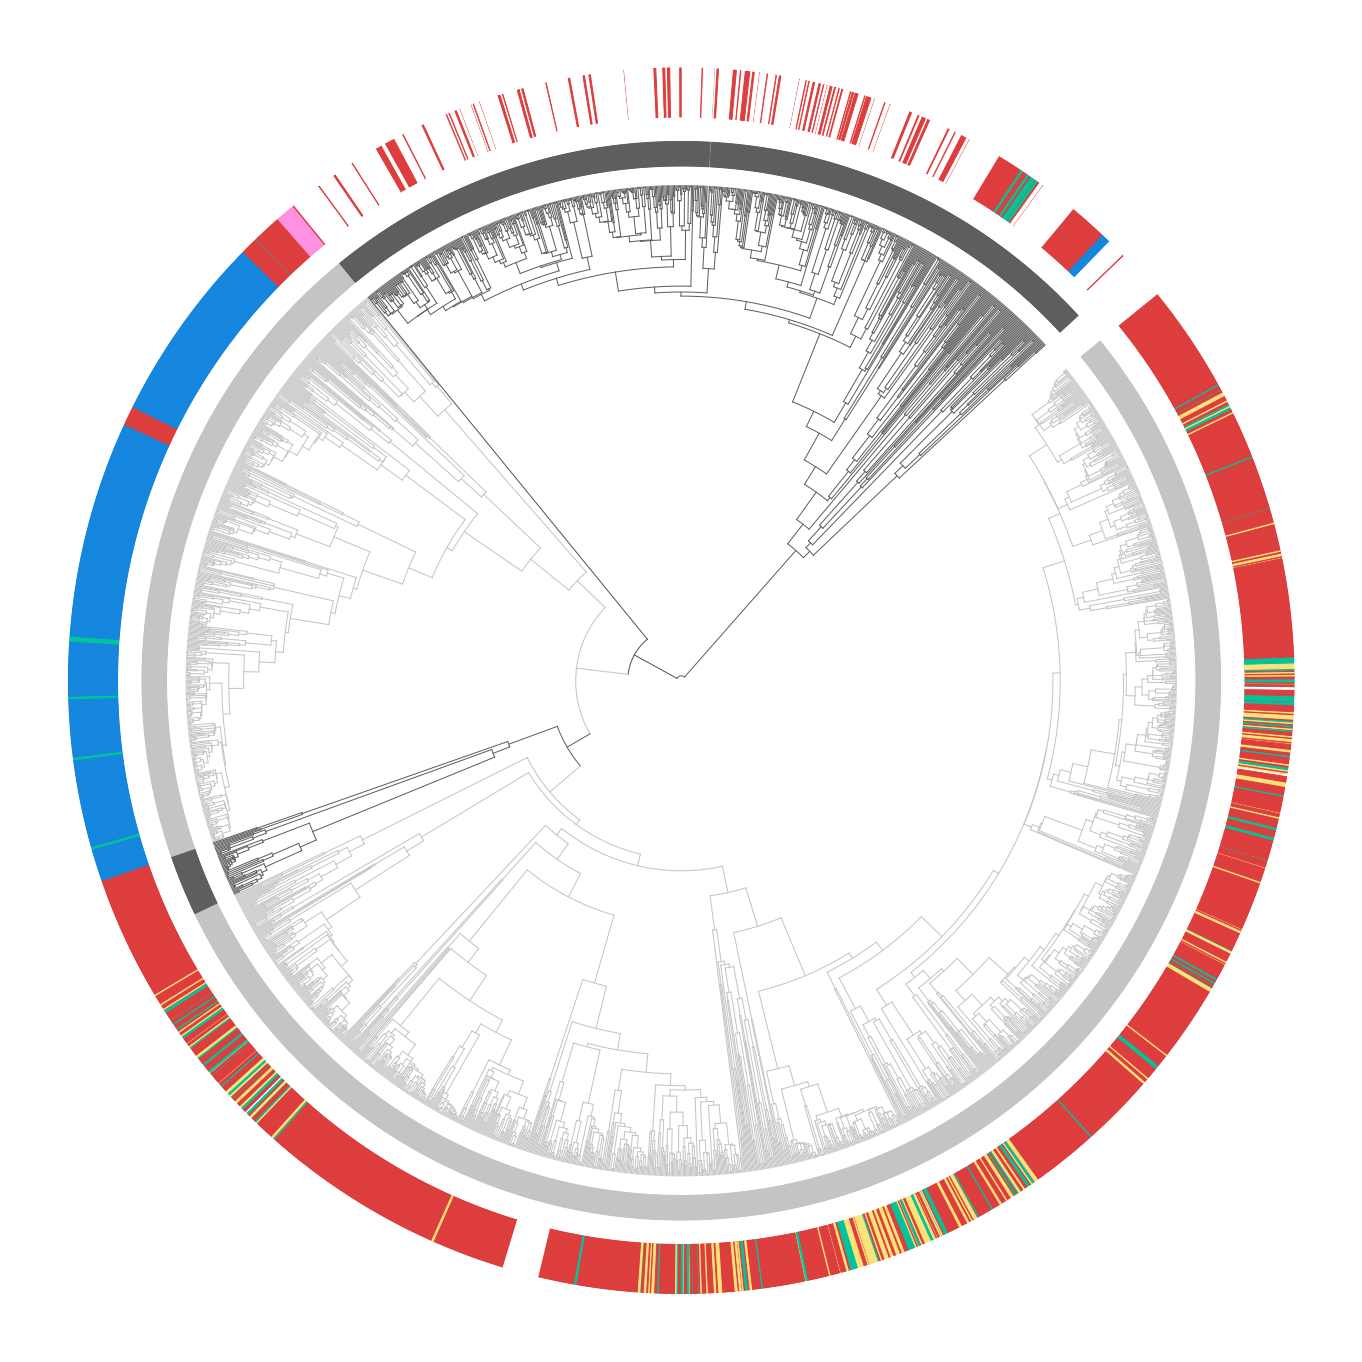

In [53]:
# shape
from matplotlib.patches import Polygon

fig,ax=plt.subplots(figsize=(24.8,24.8),facecolor='w')

circFrac=1/float(1) ## what fraction of the circle a single tree occupies
startFrom=np.pi ## start at some point along the circle
all_tips=[r.name for r in cc.Objects if isinstance(r,bt.leaf)] ## get all tip names from a tree
randomTip=np.random.randint(0,len(all_tips)) ## pick random tip
controlDepth=cc.treeHeight ## find the height of the highest tree
branchWidth=1 ## default branch width
inwardSpace=0.01
gap=0.99
effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline
baseCircle=2*np.pi*startFrom ## tree starts here along the circle
leaves=[w.name for w in cc.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
leafCount=len(leaves) ## count leaves in the tree
mostRecent=2018 ## find the most recent tip
if inwardSpace<0.0:
    labelX=-abs(inwardSpace)*1.05
else:
    labelX=inwardSpace+1.05
labelY=baseCircle+circFrac*np.pi

maxTreeHeight=max([k.absoluteTime for k in cc.Objects])
for k in cc.Objects:
# for k in cc.Objects[:100]: ## iterate through objects in the tree
    y=k.y ## get y position of current object
    x=maxTreeHeight-k.height
    xp=x-(k.parent.height-k.height)
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    xc=inwardSpace+((mostRecent-x)/controlDepth) ## transform x coordinate
    xpc=inwardSpace+((mostRecent-xp)/controlDepth) ## transform x parent's coordinate
    yc=baseCircle+circFrac*np.pi*2*(y/float(leafCount))*gap ## transform y coordinate

    if isinstance(k,bt.leaf): ## if leaf...subfamily
        begin_x=1.05
        end_x=1.10
        begin_y=baseCircle+circFrac*np.pi*2*((y-0.5)/float(leafCount))*gap
        end_y=baseCircle+circFrac*np.pi*2*((y+0.5)/float(leafCount))*gap
        ybar=np.linspace(begin_y,end_y,5)
        bottom_xs=np.sin(ybar)*begin_x
        bottom_ys=np.cos(ybar)*begin_x
        
        top_xs=np.sin(ybar)*end_x
        top_ys=np.cos(ybar)*end_x
        
        poly=plt.Polygon(list(zip(bottom_xs,bottom_ys))+list(zip(top_xs,top_ys))[::-1],
                         facecolor=k.traits['subfamcol'] if 'subfamcol' in k.traits.keys() else '#a3a3a3',
                         edgecolor=k.traits['subfamcol'] if 'subfamcol' in k.traits.keys() else '#a3a3a3',zorder=11)

        ax.add_patch(poly)
        
    if isinstance(k,bt.leaf): ## if leaf... ### leaf shape
        begin_x=1.15
        end_x=1.25
        begin_y=baseCircle+circFrac*np.pi*2*((y-0.5)/float(leafCount))*gap
        end_y=baseCircle+circFrac*np.pi*2*((y+0.5)/float(leafCount))*gap
        ybar=np.linspace(begin_y,end_y,5)
        bottom_xs=np.sin(ybar)*begin_x
        bottom_ys=np.cos(ybar)*begin_x
        
        top_xs=np.sin(ybar)*end_x
        top_ys=np.cos(ybar)*end_x
        
        poly=plt.Polygon(list(zip(bottom_xs,bottom_ys))+list(zip(top_xs,top_ys))[::-1],
                         facecolor=spp_shape_col[k.name] if k.name in spp_shape_col.keys() else '#a3a3a3',
                         edgecolor=spp_shape_col[k.name] if k.name in spp_shape_col.keys() else '#a3a3a3',zorder=11)
        
        ax.add_patch(poly)

    elif isinstance(k,bt.node): ## if node...
        yl=k.children[-1].y ## fetch first child y coordinate
        yr=k.children[0].y ## fetch last child y coordinate

        ycl=baseCircle+circFrac*np.pi*2*(yl/float(leafCount))*gap ## transform coordinates of first child
        ycr=baseCircle+circFrac*np.pi*2*(yr/float(leafCount))*gap ## transform coordinates of last child
                
        ybar=np.linspace(ycl,ycr,15) ## create a curved bar
        ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,
                color=k.traits['subfamcol'] if 'subfamcol' in k.traits.keys() else '#a3a3a3',
                ls='-',zorder=9) ## plot curved bar at the base of a node

    ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,
            color=k.traits['subfamcol'] if 'subfamcol' in k.traits.keys() else '#a3a3a3',
            ls='-',zorder=9) ## plot ancestral branch
#         ax.text(x,yc,'x=%s, yc=%s'%(x,yc,))
    startFrom+=circFrac ## increment position along circle for next tree
#Remember, if center of circle is x = 0 and y = 0, then any point's coordinates can be found from x2 + y2 = R2 (where R is radius)
ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax.set_aspect(1) ## aspect set to 1 for proper circular plot
# plt.savefig('../data_files/Tree_1_20200630.png',dpi=300)
plt.show()

In [57]:
palms['shape'].unique()
 # nas in shape for these data are climbing species or ambiguous synonyms and not plotted!
palms[palms['shape'].isna()]['species']

33                Calamus_australis
207              Calamus_formosanus
226          Plectocomia_himalayana
303                Calamus_muelleri
349                 Calamus_gamblei
                    ...            
124586            Calamus_deerratus
124589            Calamus_deerratus
124598       Eremospatha_macrocarpa
124599            Calamus_deerratus
124699    Laccosperma_secundiflorum
Name: species, Length: 7745, dtype: object

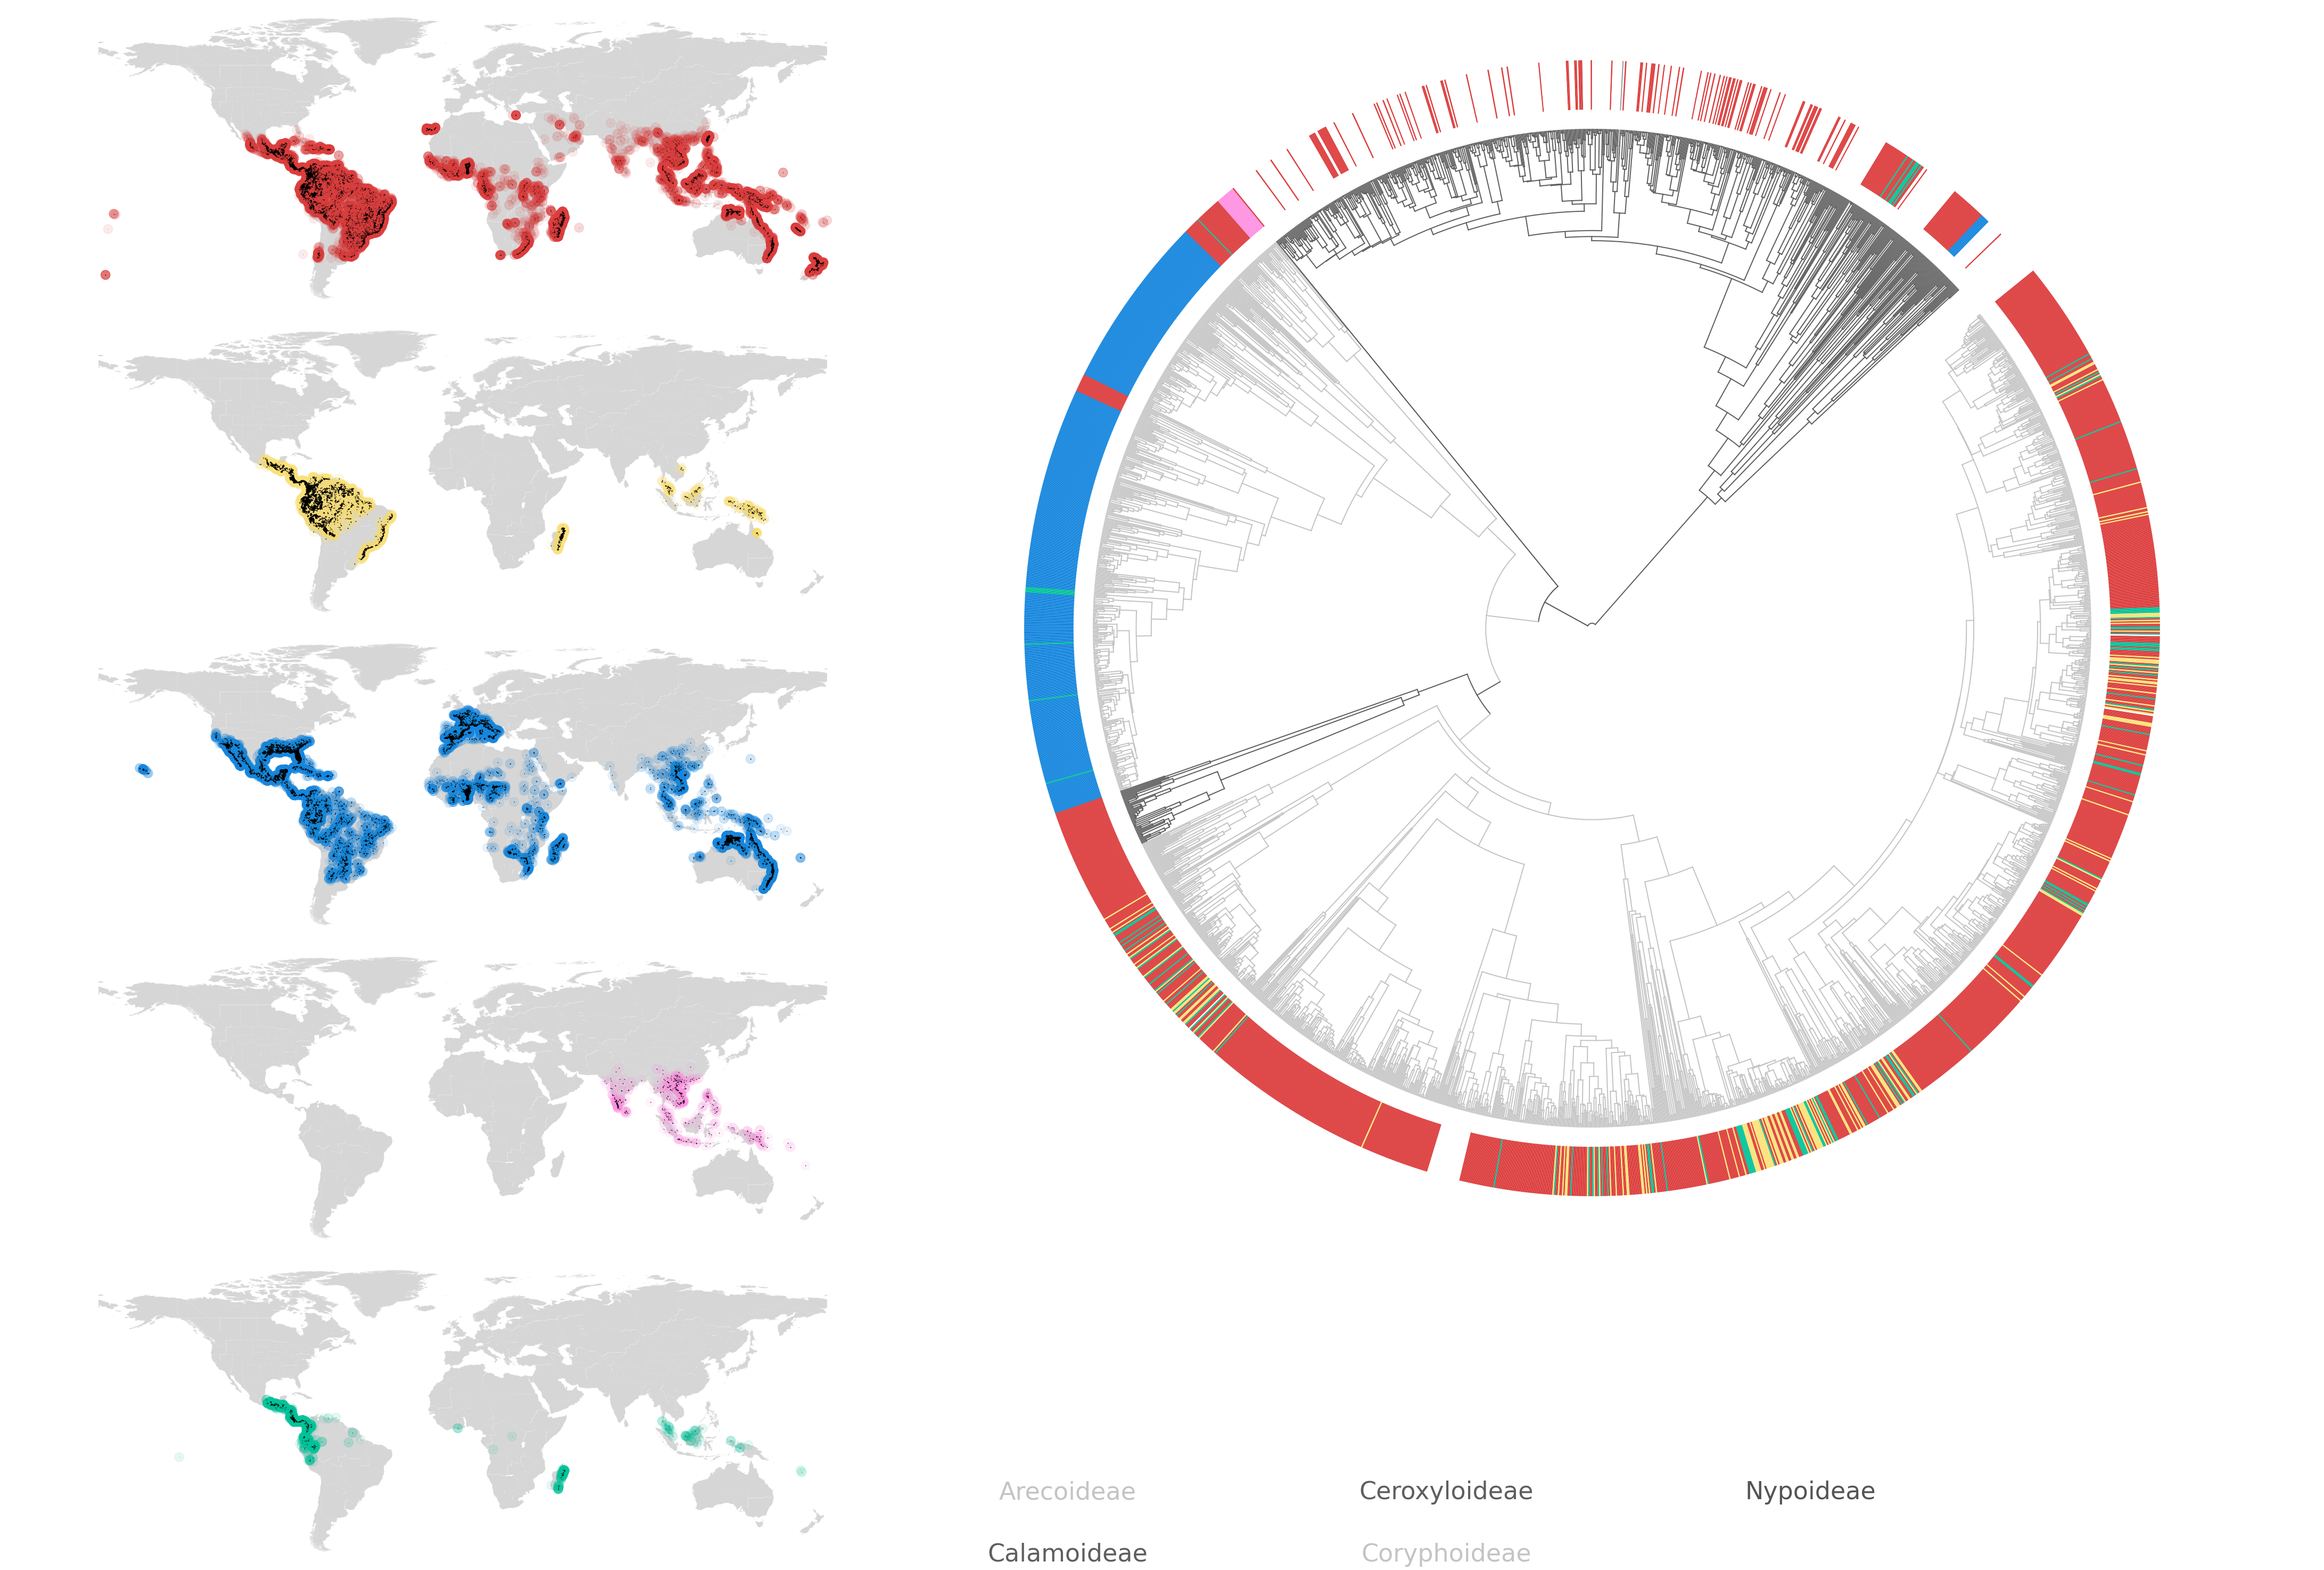

In [62]:
# colors pass greyscale differences and four colour deficiencies
# fig,ax=plt.subplots(figsize=(20,6.2),facecolor='#d6d6d6')
plt.figure(figsize=(39*2,27*2),facecolor='none')
G = gridspec.GridSpec(5,3,hspace=0.01,wspace=0,width_ratios=[0.08,1.1,2])

shape_text_dict={'cospalmate':'Palmate*','entire':'Entire','variable':'Variable','pinnate':'Pinnate','bipinnate':'Bipinnate'}
xx=0
for shape in palms['shape'].dropna().unique(): # nas in shape for these data are climbing species and not plotted!
    ####################### text boxes
    ax=plt.subplot(G[xx,0],facecolor='none')
    ax.set_facecolor('w')
    ax.text(0.2,0.5,'%s'%(shape_text_dict[shape]),fontname='Arial',rotation=90,color='w',size=50,va='center')
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.tick_params(size=0)
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ####################### maps
    ax=plt.subplot(G[xx,1],facecolor='none')
    ax.set_facecolor('w')
    for loc in polygons.keys():
        if loc in total_area.keys() and 5 < total_area[loc] < 670:
            ax.add_collection(PatchCollection(polygons[loc],facecolor='#d6d6d6',edgecolor='#d6d6d6',alpha=1,linewidth=0.1))
#         if loc not in ['ATA','COK','KIR','MHL','NRU','WSM','SLB','TON','TUV','VUT','CPV','COM','MUS','MDV','STP','SYC']:
#             ax.add_collection(PatchCollection(polygons[loc],facecolor='#d6d6d6',edgecolor='#d6d6d6',alpha=1,linewidth=2)) ## plot polygons
    
    lon=palms[palms['shape']==shape]['decimalLongitude']
    lat=palms[palms['shape']==shape]['decimalLatitude']
    ax.scatter(lon,lat,marker='o',color=palms[palms['shape']==shape]['shape'].map(shape_col_doct),alpha=0.1,s=300)
    if shape in ['pinnate','entire','cos-palmate']:
        ax.scatter(lon,lat,marker='o',color='k',alpha=1,s=0.02)
    else:
        ax.scatter(lon,lat,marker='o',color='k',alpha=1,s=0.3)
#     ax.set_aspect('equal')
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(size=0)
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    xx+=1
    
########################## phylogeny
ax4=plt.subplot(G[0:4,2])
circFrac=1/float(1) ## what fraction of the circle a single tree occupies
startFrom=np.pi ## start at some point along the circle
all_tips=[r.name for r in cc.Objects if isinstance(r,bt.leaf)] ## get all tip names from a tree
randomTip=np.random.randint(0,len(all_tips)) ## pick random tip
controlDepth=cc.treeHeight ## find the height of the highest tree
branchWidth=2 ## default branch width
inwardSpace=0.01
gap=0.99
effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline
baseCircle=2*np.pi*startFrom ## tree starts here along the circle
leaves=[w.name for w in cc.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
leafCount=len(leaves) ## count leaves in the tree
mostRecent=2018 ## find the most recent tip
if inwardSpace<0.0:
    labelX=-abs(inwardSpace)*1.05
else:
    labelX=inwardSpace+1.05
labelY=baseCircle+circFrac*np.pi

maxTreeHeight=max([k.absoluteTime for k in cc.Objects])
for k in cc.Objects:
# for k in cc.Objects[:100]: ## iterate through objects in the tree
    y=k.y ## get y position of current object
    x=maxTreeHeight-k.height
    xp=x-(k.parent.height-k.height)
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    xc=inwardSpace+((mostRecent-x)/controlDepth) ## transform x coordinate
    xpc=inwardSpace+((mostRecent-xp)/controlDepth) ## transform x parent's coordinate
    yc=baseCircle+circFrac*np.pi*2*(y/float(leafCount))*gap ## transform y coordinate

    if isinstance(k,bt.leaf): ## if leaf...
        begin_x=1.05
        end_x=1.15
        begin_y=baseCircle+circFrac*np.pi*2*((y-0.5)/float(leafCount))*gap
        end_y=baseCircle+circFrac*np.pi*2*((y+0.5)/float(leafCount))*gap
        ybar=np.linspace(begin_y,end_y,5)
        bottom_xs=np.sin(ybar)*begin_x
        bottom_ys=np.cos(ybar)*begin_x
        
        top_xs=np.sin(ybar)*end_x
        top_ys=np.cos(ybar)*end_x
        
        poly=plt.Polygon(list(zip(bottom_xs,bottom_ys))+list(zip(top_xs,top_ys))[::-1],
                         facecolor=spp_shape_col[k.name] if k.name in spp_shape_col.keys() else '#a3a3a3', edgecolor=None,zorder=11)
        
        ax4.add_patch(poly)

    elif isinstance(k,bt.node): ## if node...
        yl=k.children[-1].y ## fetch first child y coordinate
        yr=k.children[0].y ## fetch last child y coordinate

        ycl=baseCircle+circFrac*np.pi*2*(yl/float(leafCount))*gap ## transform coordinates of first child
        ycr=baseCircle+circFrac*np.pi*2*(yr/float(leafCount))*gap ## transform coordinates of last child
                
        ybar=np.linspace(ycl,ycr,15) ## create a curved bar
        ax4.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,
                color=Subfam_col_dict[k.traits['subfamily']] if 'subfamily' in k.traits else '#a3a3a3',
                ls='-',zorder=9) ## plot curved bar at the base of a node

    ax4.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,
            color=Subfam_col_dict[k.traits['subfamily']] if 'subfamily' in k.traits else '#a3a3a3',
            ls='-',zorder=9) ## plot ancestral branch
#         ax4.text(x,yc,'x=%s, yc=%s'%(x,yc,))
    startFrom+=circFrac ## increment position along circle for next tree
    ax4.set_aspect(1) ## aspect set to 1 for proper circular plot

ax4.set_xticklabels([]) ; ax4.set_yticklabels([])
[ax4.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax4.tick_params(size=0)

##### labels
ax5=plt.subplot(G[4,2])
subfam_xy_dict={'Arecoideae':(0.14,0.2),
'Calamoideae':(0.14,0),
'Ceroxyloideae':(0.4,0.2),
'Coryphoideae':(0.4,0),
'Nypoideae':(0.65,0.2)}

for key,value in Subfam_col_dict.items():
    if key != 'none':
        ax5.text(subfam_xy_dict[key][0],subfam_xy_dict[key][1],'%s'%(key),fontname='Arial',rotation=0,color=Subfam_col_dict[key],size=46,va='bottom',ha='center')
ax5.set_xticklabels([]) ; ax5.set_yticklabels([])
[ax5.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax5.tick_params(size=0)
# plt.savefig('../figures/Figure_1_all_20220811.svg',dpi=300)
plt.savefig('../figures/Figure_1_all_20220811.png',dpi=350)
# plt.savefig('../figures/Figure_1_all_20220811.pdf',dpi=300)
plt.show()
    